In [2]:
using IJulia

# Presentation Code Demo

In this notebook, I will be demonstrating the current experimental implementation of my system.

So far I have implemented the base Genetic Algorithm using fitness proportional selection, Simple crossover and uniform mutation. 

I will go on to implement more advanced genetic operators. The basic implementation served as a useful inital point to allow me to tune basic parameters such as the weighting of infeasible distances in the fitness calculation of an in individual.

I will also go onto to extend my GA to a cooperative form allowing for multiple agents to be planned in parallel without their routes intersecting.

### Example route generation

Between 2 points defined in cartesian space as (0,5) and (15,8). The road is assumed to be perfectly straight with a width of 10 (i.e. defined as 2 functions b1(x) = 0 and b2(x) = 10)

We will initially assume there are no obstacles on the road.

In [27]:
include("GA.jl")

b1(x) = 0
b2(x) = 10

start_point = Point(0,5)
goal_point = Point(15,8)

road = Road(b1,b2,[])


Road(b1, b2, Obstacle[])

We can draw this road using my `draw_road` method

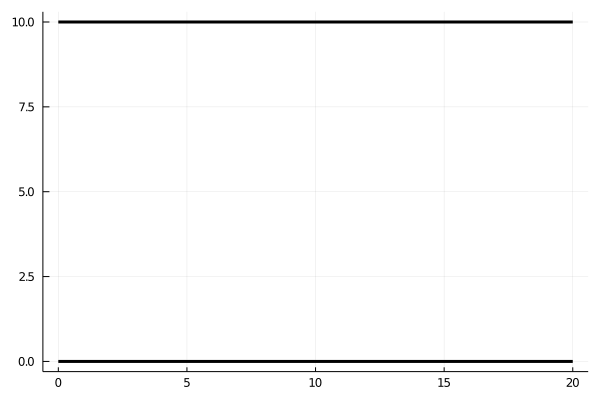

In [18]:
road_plt = draw_road(road,0,20)

We can add our start and goal points

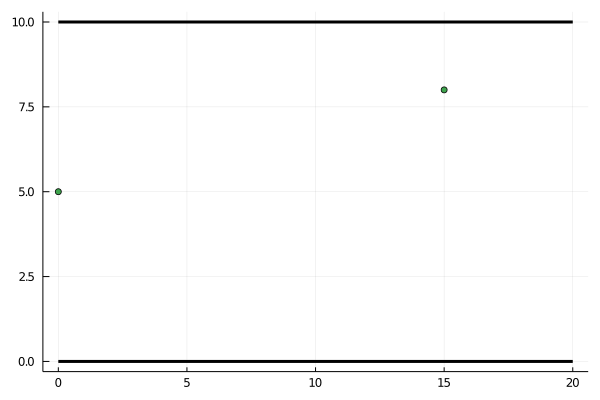

In [19]:
scatter!(road_plt,[(start_point.x,start_point.y),(goal_point.x,goal_point.y)])

We can then use my GA implementation to plan a route between these 2 points.

We will use a population size of 5 and 3 generations

In [20]:
P = GA(start_point,goal_point,road,3,5);

Plotting the results we see the folowing:

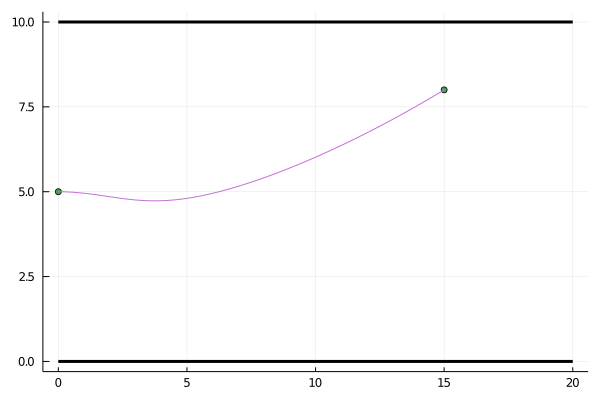

In [21]:
plotGeneration!(road_plt,P[1:1])

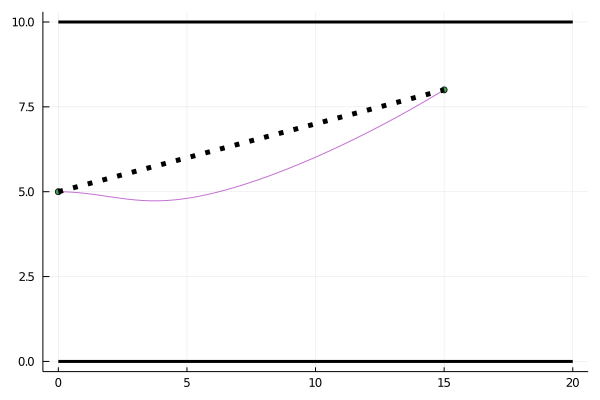

In [22]:
plot!(road_plt,[(start_point.x,start_point.y),(goal_point.x,goal_point.y)],lw=5,ls=:dot,lc=:black)

Clearly in such a scenario a simple straight line between the two points would perform better. However, where the GA approach becomes more relevant is in the avoidance of obstacles.

In [23]:
o1 = Circle(1,Point(15,5))
o2 = Circle(1.2,Point(2.5,7))
o3 = Circle(0.8,Point(7,6))
o4 = Circle(0.8,Point(12,2))

road = Road(b1,b2,[o1,o2,o3,o4])


Road(b1, b2, Obstacle[Circle(1, Point(15, 5)), Circle(1.2, Point(2.5, 7)), Circle(0.8, Point(7, 6)), Circle(0.8, Point(12, 2))])

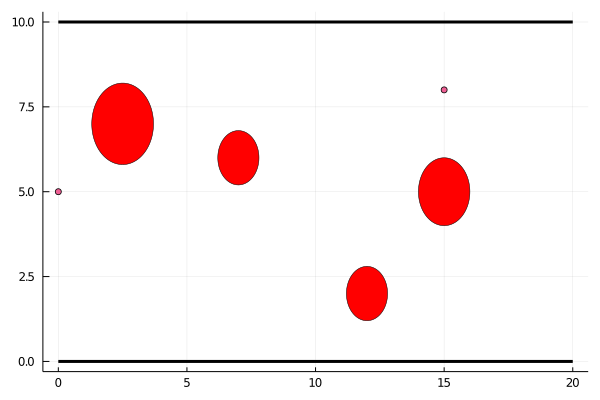

In [24]:
road_plt = draw_road(road,0,20)
scatter!(road_plt,[(start_point.x,start_point.y),(goal_point.x,goal_point.y)])

If we were to add our straight line now, we find that this is an infeasible route

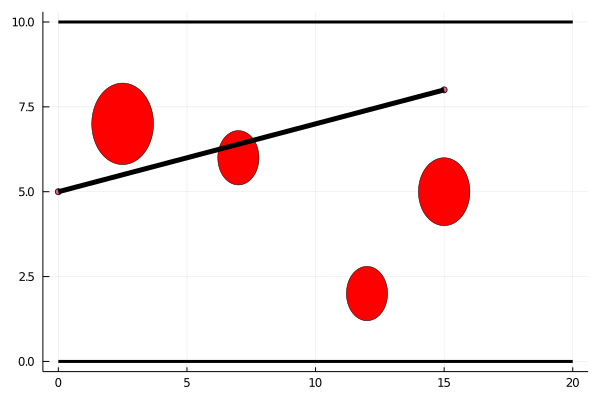

In [25]:
plot!(road_plt,[(start_point.x,start_point.y),(goal_point.x,goal_point.y)],lw=5,lc=:black)

However, planning using our GA yields the following:

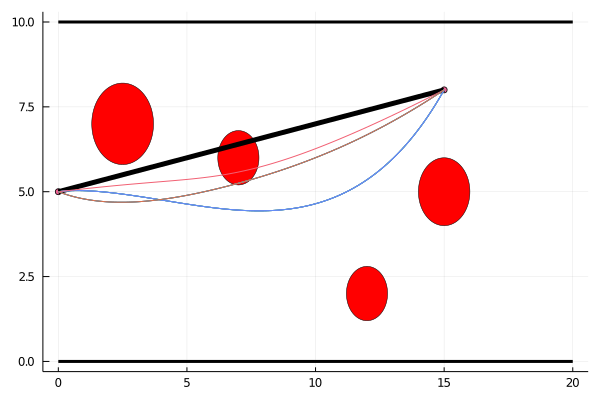

In [28]:
P = GA(start_point,goal_point,road,3,5);
plotGeneration!(road_plt,P)

You might see that there are fewer lines displayed than the 5 individuals we started with. This is because the final output of the GA filters any infeasible solutions. We do not remove such solutions from the _gene pool_ during generation as sometimes the most optimal solutions are very close to the infeasible boundary in the search space.

Below you can see an example of the learning process over the course of 100 generations for a simliar road space problem

![foo](https://sambarrett.online/Y4-Diss/100gens-3.gif)
Clearly you can see that the search converges after around 20 generations with the best solution (shown in bold) being maintained for the rest of the process.

This is an area in GAs that require manual tuning. You do not want your GA to band around too much so that it never settles on a near-optimal solution but you do not want it to get stuck in local minima. This is an issue I need to look at closer in the future. 

Approaches to dealing with this include simmulated annealing and different selection, mutation and crossover procedures.

Changing genetic operators is very simple with my current code base. The shape of my GA currently has the very idiomatic form:

```julia
 while true && n_gens > 0 && length(P) > 0# Replace with stopping criteria
        P = (P
            |> roulette_selection  # Selection operator
            |> simple_crossover # Crossover operator
            |> new_pop -> append!(P, new_pop)  # Add newly generated individuals to population
            |> uniform_mutation # apply mutation operator
            |> P -> begin map(p -> p.fitness = p |> 𝓕, P); P end # recalculate fitness of population after mutation
            |> P -> map(repair, P)  # repair infeasible solutions
            |> P -> sort(P, by= p -> p.fitness) # Sort my fitness
            |> P -> filter(isValid, P) # remove invalid solutions
            |> P -> P[1:n] # take top n
        )
        n_gens = n_gens - 1
    end
```

So the process of changing an operator is as simple as piping the population into a different function of the shape type.

## Going Forward

If I were to use my GA to generate a separate route for a different agent between two different points:

In [14]:
start_point = Point(0.5,5.2)
goal_point = Point(16,1)

P2 = GA(start_point,goal_point,road,3,5);


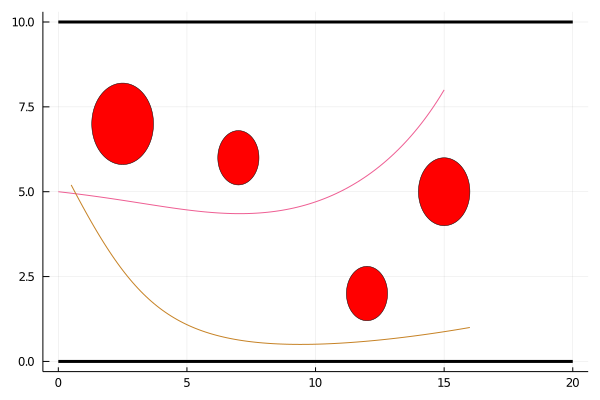

In [15]:
rg = draw_road(road,0,20)
plotGeneration!(rg,[P[1],P2[1]])

You can clearly see an intersection in their routes. Whilst this is not inherently bad, it has the potential to be infeasible or in the real-world result in a crash.

Bezier curves are drawn using a parameter `t`, if these curves intersect at the same value of `t` this set of routes would result in a incident.